In [2]:
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt

# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#opening data
import os
import pathlib
import warnings

#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [3]:
#load data - store it in train dataframe
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', 'events_England.json') # delete
with open(path) as f: # delete #
    data = json.load(f) # delete #
train = pd.DataFrame(data) # delete #
    
#potential data collection error handling
train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643032 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643032 non-null  int64  
 1   subEventName  643032 non-null  object 
 2   tags          643032 non-null  object 
 3   playerId      643032 non-null  int64  
 4   positions     643032 non-null  object 
 5   matchId       643032 non-null  int64  
 6   eventName     643032 non-null  object 
 7   teamId        643032 non-null  int64  
 8   matchPeriod   643032 non-null  object 
 9   eventSec      643032 non-null  float64
 10  subEventId    643032 non-null  object 
 11  id            643032 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 63.8+ MB


In [12]:
train['eventName'].unique()

array(['Pass', 'Duel', 'Foul', 'Free Kick', 'Shot', 'Save attempt',
       'Others on the ball', 'Interruption', 'Goalkeeper leaving line',
       'Offside'], dtype=object)

In [11]:
train['subEventName'].unique()

array(['Simple pass', 'High pass', 'Head pass', 'Air duel',
       'Ground loose ball duel', 'Smart pass', 'Launch',
       'Ground defending duel', 'Ground attacking duel', 'Foul',
       'Free Kick', 'Cross', 'Shot', 'Reflexes', 'Touch', 'Clearance',
       'Ball out of the field', 'Throw in', 'Goal kick', 'Corner',
       'Goalkeeper leaving line', 'Hand pass', 'Acceleration',
       'Save attempt', '', 'Free kick cross', 'Free kick shot',
       'Hand foul', 'Violent Foul', 'Protest', 'Whistle',
       'Out of game foul', 'Late card foul', 'Penalty', 'Time lost foul',
       'Simulation'], dtype=object)

In [20]:
train['tags']

0                                            [{'id': 1801}]
1                                            [{'id': 1801}]
2                                            [{'id': 1801}]
3                                            [{'id': 1801}]
4                                            [{'id': 1801}]
                                ...                        
643145                                                   []
643146             [{'id': 302}, {'id': 801}, {'id': 1801}]
643147                          [{'id': 701}, {'id': 1802}]
643148                          [{'id': 703}, {'id': 1801}]
643149    [{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...
Name: tags, Length: 643032, dtype: object

In [5]:
def calulatexG(df, npxG):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.
    npxG : boolean
        True if xG should not include penalties, False elsewhere.

    Returns
    -------
    xG_sum: dataframe
        dataframe with sum of Expected Goals for players during the season.

    """
    #very basic xG model based on
    shots = df.loc[df["eventName"] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    #calculate distance and angle
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, 
                              np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), 
                              np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
        #headers have id = 403
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)

    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers,
                               family=sm.families.Binomial()).fit()
    #non-headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers,
                               family=sm.families.Binomial()).fit()
    #assigning xG
    #headers
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle']))
    headers = headers.assign(xG = xG)

    #non-headers
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle']))
    non_headers = non_headers.assign(xG = xG)

    if npxG == False:
        #find pens
        penalties = df.loc[df["subEventName"] == "Penalty"]
        #assign 0.8
        penalties = penalties.assign(xG = 0.8)
        #concat, group and sum
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]], penalties[["playerId", "xG"]]])
        xG_sum = all_shots_xg.groupby(["playerId"])["xG"].sum().sort_values(ascending = False).reset_index()
    else:
        #concat, group and sum
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]]])
        all_shots_xg.rename(columns = {"xG": "npxG"}, inplace = True)
        xG_sum = all_shots_xg.groupby(["playerId"])["npxG"].sum().sort_values(ascending = False).reset_index()
    #group by player and sum

    return xG_sum

#making function
npxg = calulatexG(train, npxG = True)
#investigate structure
npxg.head(3)

,playerId,npxG
0,8717,22.014180
1,120353,17.215819
2,11066,14.144484


In [6]:
def FinalThird(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    final_third: dataframe
        dataframe with number of passes ending in final third and receptions in that area for a player.

    """
    df = df.copy()
    #need player who had received the ball
    df["nextPlayerId"] = df["playerId"].shift(-1)
    passes = df.loc[train["eventName"] == "Pass"].copy()
    #changing coordinates
    passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

    #get accurate passes
    accurate_passes = passes.loc[passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    #get passes into final third
    final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]

    #passes into final third by player
    ftp_player = final_third_passes.groupby(["playerId"]).end_x.count().reset_index()
    ftp_player.rename(columns = {'end_x':'final_third_passes'}, inplace=True)

    #receptions of accurate passes in the final third
    rtp_player = final_third_passes.groupby(["nextPlayerId"]).end_x.count().reset_index()
    rtp_player.rename(columns = {'end_x':'final_third_receptions', "nextPlayerId": "playerId"}, inplace=True)

    #outer join not to lose values
    final_third = ftp_player.merge(rtp_player, how = "outer", on = ["playerId"])
    return final_third

final_third = FinalThird(train)
#investigate structure
final_third.head(3)

,playerId,final_third_passes,final_third_receptions
0,36,186.0,83.0
1,38,62.0,66.0
2,48,392.0,188.0


In [7]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player

    """
    #find air duels
    air_duels = df.loc[df["subEventName"] == "Air duel"]
    #703 is the id of a won duel
    won_air_duels = air_duels.loc[air_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]

    #group and sum air duels
    wad_player =  won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)

    #find ground duels won
    ground_duels = df.loc[df["subEventName"].isin(["Ground attacking duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]

    wgd_player =  won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'ground_duels_won'}, inplace=True)

    #outer join
    duels_won = wgd_player.merge(wad_player, how = "outer", on = ["playerId"])
    return duels_won

duels = wonDuels(train)
#investigate structure
duels.head(3)

,playerId,ground_duels_won,air_duels_won
0,0,2244.0,1061.0
1,36,13.0,23.0
2,38,7.0,11.0


In [8]:
def smartPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    sp_player: dataframe
        dataframe with number of smart passes.

    """
    #get smart passes
    smart_passes = df.loc[df["subEventName"] == "Smart pass"]
    #find accurate
    smart_passes_made = smart_passes.loc[smart_passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]

    #sum by player
    sp_player =  smart_passes_made.groupby(["playerId"]).eventId.count().reset_index()
    sp_player.rename(columns = {'eventId':'smart_passes'}, inplace=True)

    return sp_player

smart_passes = smartPasses(train)
#investigate structure
smart_passes.head(3)

,playerId,smart_passes
0,36,1
1,38,1
2,48,3


In [9]:
def GoalsAssistsKeyPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    data: dataframe
        dataframe with number of (non-penalty) goals, assists and key passes.

    """
    #get goals
    shots = df.loc[df["subEventName"] == "Shot"]
    goals = shots.loc[shots.apply (lambda x:{'id':101} in x.tags, axis = 1)]
    #get assists
    passes = df.loc[df["eventName"] == "Pass"]
    assists = passes.loc[passes.apply (lambda x:{'id':301} in x.tags, axis = 1)]
    #get key passes
    key_passes = passes.loc[passes.apply (lambda x:{'id':302} in x.tags, axis = 1)]

    #goals by player
    g_player =  goals.groupby(["playerId"]).eventId.count().reset_index()
    g_player.rename(columns = {'eventId':'goals'}, inplace=True)

    #assists by player
    a_player =  assists.groupby(["playerId"]).eventId.count().reset_index()
    a_player.rename(columns = {'eventId':'assists'}, inplace=True)

    #key passes by player
    kp_player =  key_passes.groupby(["playerId"]).eventId.count().reset_index()
    kp_player.rename(columns = {'eventId':'key_passes'}, inplace=True)

    data = g_player.merge(a_player, how = "outer", on = ["playerId"]).merge(kp_player, how = "outer", on = ["playerId"])
    return data

gakp = GoalsAssistsKeyPasses(train)
#investigate structure
gakp.head(3)

,playerId,goals,assists,key_passes
0,54,10.0,5.0,25.0
1,74,1.0,NaN,1.0
2,93,2.0,5.0,14.0


In [84]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]),"data", "Wyscout", "minutes_played", 'minutes_played_per_game_England.json')
minutes_per_game = pd.read_json(path, encoding='unicode-escape')
# with open(path) as f:
#     minutes_per_game = json.load(f)
# minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
minutes.head(3)

,playerId,minutesPlayed
0,36,1238
1,38,382
2,48,3343


In [85]:
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])

summary = summary.merge(npxg, how="left", on=["playerId"])\
                .merge(final_third, how="left", on=["playerId"])\
                .merge(duels, how="left", on=["playerId"])\
                .merge(smart_passes, how="left", on=["playerId"])\
                .merge(gakp, how="left", on=["playerId"])
summary = minutes.merge(summary, how="left", on=["playerId"])

summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
summary.head(3)

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes
0,36,1238,0.604683,186.0,83.0,13.0,23.0,1.0,0.0,0.0,2.0
2,48,3343,1.236777,392.0,188.0,50.0,137.0,3.0,0.0,0.0,3.0
3,54,3348,6.350951,818.0,800.0,102.0,15.0,42.0,10.0,5.0,25.0


In [86]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 512
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   playerId                397 non-null    int64  
 1   minutesPlayed           397 non-null    int64  
 2   npxG                    397 non-null    float64
 3   final_third_passes      397 non-null    float64
 4   final_third_receptions  397 non-null    float64
 5   ground_duels_won        397 non-null    float64
 6   air_duels_won           397 non-null    float64
 7   smart_passes            397 non-null    float64
 8   goals                   397 non-null    float64
 9   assists                 397 non-null    float64
 10  key_passes              397 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 37.2 KB


In [87]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]),"data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
# with open(path) as f:
#     players = json.load(f).encode('utf8')
# player_df = pd.DataFrame(players)

forwards = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Forward", axis = 1)]
forwards.rename(columns = {'wyId':'playerId'}, inplace=True)

to_merge = forwards[['playerId', 'shortName']]
summary = summary.merge(to_merge, how="inner", on=["playerId"])
summary.head(3)

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes,shortName
0,471,756,1.774309,39.0,69.0,37.0,48.0,4.0,2.0,0.0,1.0,W. Bony
1,3324,2143,10.403442,199.0,340.0,170.0,48.0,9.0,11.0,4.0,6.0,Álvaro Morata
2,3326,618,0.900291,43.0,81.0,33.0,0.0,3.0,1.0,1.0,3.0,Jesé Rodríguez


In [88]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   playerId                76 non-null     int64  
 1   minutesPlayed           76 non-null     int64  
 2   npxG                    76 non-null     float64
 3   final_third_passes      76 non-null     float64
 4   final_third_receptions  76 non-null     float64
 5   ground_duels_won        76 non-null     float64
 6   air_duels_won           76 non-null     float64
 7   smart_passes            76 non-null     float64
 8   goals                   76 non-null     float64
 9   assists                 76 non-null     float64
 10  key_passes              76 non-null     float64
 11  shortName               76 non-null     object 
dtypes: float64(9), int64(2), object(1)
memory usage: 7.7+ KB


In [94]:
minutes_per_game.head(3)

,playerId,shortName,matchId,teamId,teamName,player_in_min,player_out_min,minutesPlayed,red_card
0,9206,C. Wood,2500089,1646,Burnley FC,0,61,61,0
1,9127,S. Vokes,2500089,1646,Burnley FC,61,95,34,0
2,93,J. Guðmunds­son,2500089,1646,Burnley FC,0,80,80,0


In [95]:
possesion_dict = {}

#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possesion_dict.keys():
        possesion_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60

    #get the dataframe of events from the game
    match_df = train.loc[train["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] = (match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] 
                                                                + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1])
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"]\
                                    .isin(["Air duel", "Ground defending duel","Ground loose ball duel"])]\
                                        .loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    
    #take team passes
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
    possesion_dict[str(player_id)]["all_passes"] += len(all_passes)

In [96]:
possesion_dict

{'9206': {'team_passes': 8653, 'all_passes': 19358},
 '9127': {'team_passes': 5097, 'all_passes': 11610},
 '93': {'team_passes': 14957, 'all_passes': 34126},
 '9179': {'team_passes': 378, 'all_passes': 802},
 '10108': {'team_passes': 7420, 'all_passes': 17123},
 '8433': {'team_passes': 13085, 'all_passes': 29551},
 '8125': {'team_passes': 18037, 'all_passes': 41079},
 '9433': {'team_passes': 14990, 'all_passes': 33575},
 '8980': {'team_passes': 12531, 'all_passes': 28448},
 '8643': {'team_passes': 12072, 'all_passes': 27557},
 '12242': {'team_passes': 16477, 'all_passes': 37717},
 '8925': {'team_passes': 6097, 'all_passes': 13405},
 '8284': {'team_passes': 10414, 'all_passes': 23634},
 '532949': {'team_passes': 2, 'all_passes': 2},
 '259531': {'team_passes': 361, 'all_passes': 717},
 '7989': {'team_passes': 11513, 'all_passes': 25268},
 '245813': {'team_passes': 3784, 'all_passes': 7733},
 '11669': {'team_passes': 12107, 'all_passes': 25264},
 '239411': {'team_passes': 986, 'all_passes

In [97]:
#calculate possesion for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possesion_dict.items()}
#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possesion"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)

#merge it
summary = summary.merge(percentage_df, how="left", on=["playerId"])

In [98]:
percentage_df.head(3)

,playerId,possesion
0,9206,0.446999
1,9127,0.439018
2,93,0.438288


In [99]:
summary.head()

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes,shortName,possesion
0,471,756,1.774309,39.0,69.0,37.0,48.0,4.0,2.0,0.0,1.0,W. Bony,0.461731
1,3324,2143,10.403442,199.0,340.0,170.0,48.0,9.0,11.0,4.0,6.0,Álvaro Morata,0.560137
2,3326,618,0.900291,43.0,81.0,33.0,0.0,3.0,1.0,1.0,3.0,Jesé Rodríguez,0.406015
3,3327,1775,6.118932,133.0,175.0,50.0,134.0,3.0,4.0,1.0,4.0,Joselu,0.419726
4,3348,441,0.711633,49.0,69.0,31.0,0.0,4.0,1.0,0.0,1.0,Deulofeu,0.483754


In [100]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]

#calculate value adjusted
for column in summary.columns[2:11]:
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["possesion"])*90/x["minutesPlayed"], axis = 1)

In [101]:
summary_adjusted.head()

,shortName,npxG_adjusted_per90,final_third_passes_adjusted_per90,final_third_receptions_adjusted_per90,ground_duels_won_adjusted_per90,air_duels_won_adjusted_per90,smart_passes_adjusted_per90,goals_adjusted_per90,assists_adjusted_per90,key_passes_adjusted_per90
0,W. Bony,0.457468,10.055333,17.790205,9.539675,12.375795,1.031316,0.515658,0.000000,0.257829
1,Álvaro Morata,0.780015,14.920356,25.492065,12.746032,3.598880,0.674790,0.824743,0.299907,0.449860
2,Jesé Rodríguez,0.322920,15.423409,29.053398,11.836570,0.000000,1.076052,0.358684,0.358684,1.076052
3,Joselu,0.739186,16.066810,21.140539,6.040154,16.187613,0.362409,0.483212,0.120803,0.483212
4,Deulofeu,0.300217,20.671673,29.109090,13.077997,0.000000,1.687484,0.421871,0.000000,0.421871


In [123]:
#player to investigate - Mohammed Salah
#only his statistics
salah_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == "Mohamed Salah"]

#columns similar together
salah_adjusted = salah_adjusted[[
    'npxG_adjusted_per90', "goals_adjusted_per90", 
    "assists_adjusted_per90", "key_passes_adjusted_per90", "smart_passes_adjusted_per90",
    "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90", 
    "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]

#take only necessary columns - exclude playerId
adjusted_columns = salah_adjusted.columns[:]

#values to mark on the plot
values = [round(salah_adjusted[column].iloc[0],2) for column in adjusted_columns]

#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], salah_adjusted[column].iloc[0])) for column in adjusted_columns]

In [124]:
salah_adjusted

,npxG_adjusted_per90,goals_adjusted_per90,assists_adjusted_per90,key_passes_adjusted_per90,smart_passes_adjusted_per90,final_third_passes_adjusted_per90,final_third_receptions_adjusted_per90,ground_duels_won_adjusted_per90,air_duels_won_adjusted_per90
61,0.870522,1.567523,0.353957,0.556218,1.264131,21.338537,31.350457,10.062485,0.505653


In [125]:
values

[0.87, 1.57, 0.35, 0.56, 1.26, 21.34, 31.35, 10.06, 0.51]

In [126]:
percentiles

[93, 100, 80, 57, 88, 80, 88, 60, 11]

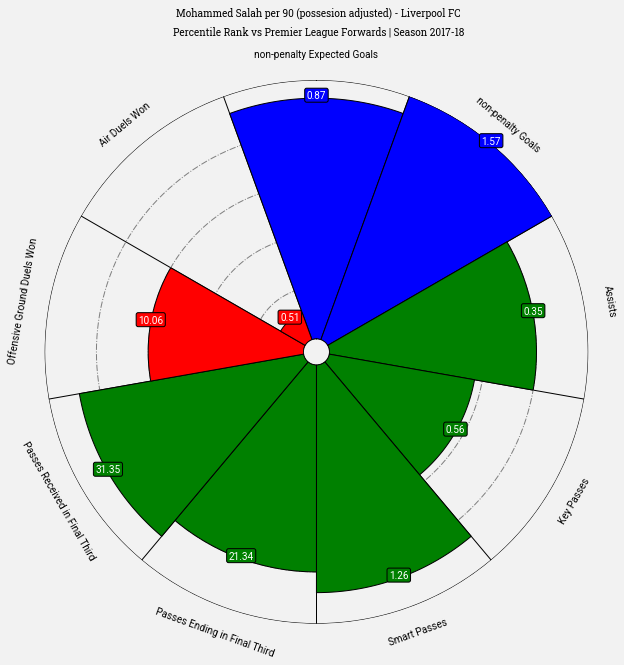

In [128]:
names = [
    "non-penalty Expected Goals", "non-penalty Goals", 
    "Assists", "Key Passes", "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", 
    "Offensive Ground Duels Won", "Air Duels Won"]
baker = PyPizza(
    params=names,                   # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

slice_colors = ["blue"] * 2 + ["green"] * 5 + ["red"] * 2
text_colors = ["white"]*9
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/" "RobotoSlab%5Bwght%5D.ttf?raw=true"))
fig, ax = baker.make_pizza(
    percentiles,          # list of values: either the raw metric values or the percentile values can be chosen to plot
    figsize=(10,10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    # values to be used when plotting slices
    kwargs_slices=dict(
        facecolor="cornflowerblue", 
        edgecolor="#000000", 
        zorder=2, 
        linewidth=1),
    # values to be used when adding parameter
    kwargs_params=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        va="center"), 
    # values to be used when adding parameter-values
    kwargs_values=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        zorder=3,
        bbox=dict(
            edgecolor="#000000", 
            facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", 
            lw=1
        )
    )
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))

# add title
fig.text(
    0.515, 
    0.97, 
    "Mohammed Salah per 90 (possesion adjusted) - Liverpool FC", 
    size=18,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

# add subtitle
fig.text(
    0.515, 
    0.942,
    "Percentile Rank vs Premier League Forwards | Season 2017-18",
    size=15,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

plt.show()